Importing all the modules

In [1]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import pandas as pd
import os
import re
from string import punctuation
from datetime import datetime

Now to pull in the .json file as a DataFrame and take a look.

In [2]:
df = pd.read_json('jeopardy.json')
df

,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,Jeopardy!,4680
...,...,...,...,...,...,...,...
216925,RIDDLE ME THIS,2006-05-11,'This Puccini opera turns on the solution to 3...,$2000,Turandot,Double Jeopardy!,4999
216926,"""T"" BIRDS",2006-05-11,'In North America this term is properly applie...,$2000,a titmouse,Double Jeopardy!,4999
216927,AUTHORS IN THEIR YOUTH,2006-05-11,"'In Penny Lane, where this ""Hellraiser"" grew u...",$2000,Clive Barker,Double Jeopardy!,4999
216928,QUOTATIONS,2006-05-11,"'From Ft. Sill, Okla. he made the plea, Arizon...",$2000,Geronimo,Double Jeopardy!,4999


I think the easiest part to tackle will be getting the values converted to binary (low vs high). Will have to remove the $'s, then convert it from a string to an int.... not sure what to do with the 'None' I see there at the bottom, though... I feel like they should be considered 'high value' since they're the Final Jeopardy questions and the game often comes down to who bids high on these and gets it right.

In [3]:
df.sort_values(by='value', ascending=False)

,category,air_date,question,value,answer,round,show_number
205851,BEFORE HE WAS PRESIDENT,2006-03-21,"'He was editor & owner of the Marion, Ohio Sta...",$900,Warren G. Harding,Double Jeopardy!,4962
70678,PRESENTS,2000-12-26,'In March 1999 the makers of this board gane i...,$900,Monopoly,Jeopardy!,3757
16547,"STARTS WITH ""Z""",1989-12-01,'Collective name of Frank Beard & the 2 guys w...,$900,ZZ Top,Jeopardy!,1210
110619,HE'S THE MAYOR,1999-12-22,"'Carmel, California<br />1986-1988'",$900,Clint Eastwood,Double Jeopardy!,3523
148268,I NEED A TUDOR,2000-04-07,"'Henry VIII's big brother, who never got to ru...",$900,Arthur,Double Jeopardy!,3600
...,...,...,...,...,...,...,...
216686,MAJOR LEAGUE BASEBALL TEAM NAMES,2001-10-19,'This team received its name after an 1890 inc...,None,Pittsburgh Pirates,Final Jeopardy!,3940
216746,SKYSCRAPERS,2010-12-16,'After a construction boom fueled by oil & gas...,None,Moscow,Final Jeopardy!,6044
216807,NATIONAL CAPITALS,2006-09-29,"'This city's website calls it ""the last divide...",None,Nicosia,Final Jeopardy!,5070
216868,BESTSELLING AUTHORS,2007-03-23,'He had the year's bestselling novel a record ...,None,John Grisham,Final Jeopardy!,5195


In [4]:
df.groupby('value').count()

,category,air_date,question,answer,round,show_number
value,,,,,,
"$1,000",2101,2101,2101,2101,2101,2101
"$1,020",1,1,1,1,1,1
"$1,100",63,63,63,63,63,63
"$1,111",2,2,2,2,2,2
"$1,183",1,1,1,1,1,1
...,...,...,...,...,...,...
"$9,000",8,8,8,8,8,8
"$9,200",1,1,1,1,1,1
"$9,500",1,1,1,1,1,1


hmmm... ok, I'm pretty sure that if nobody got any points from the Final Jeopardy question, it's 'None'. And if they got it right, it's the points they gained. So we'll put the None's to 0.

In [5]:
df['value'] = df['value'].str.replace('[^0-9]', '', regex=True)
df['value'] = df['value'].fillna(0)
df['value'] = df['value'].astype('int')
#I was trying to use regex to replace $'s, commas, and 'None'.
#But turns out 'None' were null values. Finally got it sorted.
df

,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",200,John Adams,Jeopardy!,4680
...,...,...,...,...,...,...,...
216925,RIDDLE ME THIS,2006-05-11,'This Puccini opera turns on the solution to 3...,2000,Turandot,Double Jeopardy!,4999
216926,"""T"" BIRDS",2006-05-11,'In North America this term is properly applie...,2000,a titmouse,Double Jeopardy!,4999
216927,AUTHORS IN THEIR YOUTH,2006-05-11,"'In Penny Lane, where this ""Hellraiser"" grew u...",2000,Clive Barker,Double Jeopardy!,4999
216928,QUOTATIONS,2006-05-11,"'From Ft. Sill, Okla. he made the plea, Arizon...",2000,Geronimo,Double Jeopardy!,4999


In [6]:
df.dtypes

category       object
air_date       object
question       object
value           int64
answer         object
round          object
show_number     int64
dtype: object

In [7]:
df['value'].describe()

count    216930.000000
mean        739.988476
std         639.822693
min           0.000000
25%         400.000000
50%         600.000000
75%        1000.000000
max       18000.000000
Name: value, dtype: float64

(array([1.2675e+04, 3.0460e+04, 5.0910e+04, 9.0170e+03, 2.0581e+04,
        3.1865e+04, 2.1755e+04, 6.6000e+01, 1.1852e+04, 2.3000e+02,
        1.1588e+04, 4.5000e+01, 2.1300e+02, 1.2832e+04, 1.7100e+02,
        2.4000e+01, 3.6000e+02, 8.3000e+01, 8.9000e+01, 7.7600e+02]),
 array([   0.,  150.,  300.,  450.,  600.,  750.,  900., 1050., 1200.,
        1350., 1500., 1650., 1800., 1950., 2100., 2250., 2400., 2550.,
        2700., 2850., 3000.]),
 <BarContainer object of 20 artists>)

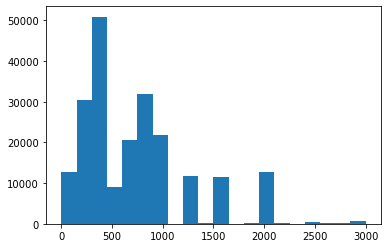

In [20]:
import matplotlib.pyplot as plt
plt.hist(df['value'], bins=20, range=(0,3000))

Just trying to get a feel for high vs low value. I think I'll go with anything over 600 is high, 600 and lower is low.

In [53]:
df['high_low'] = [1 if x>600 else 0 for x in df['value']]
df

,category,air_date,question,value,answer,round,show_number,high_low
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",200,Copernicus,Jeopardy!,4680,0
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,200,Jim Thorpe,Jeopardy!,4680,0
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,200,Arizona,Jeopardy!,4680,0
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",200,McDonald\'s,Jeopardy!,4680,0
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",200,John Adams,Jeopardy!,4680,0
...,...,...,...,...,...,...,...,...
216925,RIDDLE ME THIS,2006-05-11,'This Puccini opera turns on the solution to 3...,2000,Turandot,Double Jeopardy!,4999,1
216926,"""T"" BIRDS",2006-05-11,'In North America this term is properly applie...,2000,a titmouse,Double Jeopardy!,4999,1
216927,AUTHORS IN THEIR YOUTH,2006-05-11,"'In Penny Lane, where this ""Hellraiser"" grew u...",2000,Clive Barker,Double Jeopardy!,4999,1
216928,QUOTATIONS,2006-05-11,"'From Ft. Sill, Okla. he made the plea, Arizon...",2000,Geronimo,Double Jeopardy!,4999,1


Now that we have our list for the high vs low answers, time to get our list of lemmatized list of words for all the questions.

In [40]:
#Had to install a few things due to erros.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/morgan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/morgan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/morgan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/morgan/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

Now to setup our clean_wordlist funciton.

Used a very similar setup to what we did in the trianing. Took some testing to get it right, but it seems to be working now.

In [91]:
english_stopwords = stopwords.words('english')
english_stopwords += punctuation
def clean_wordlist(questions):
    corpus = ''
    wordlist = []
    lemmatizer = WordNetLemmatizer()
    for q in questions:
        corpus += q.lower()
    wordlist += [lemmatizer.lemmatize(word) for word in
                word_tokenize(corpus) if word not in english_stopwords]
    return wordlist

In [97]:
allquestions = [' '.join(clean_wordlist([x])) for x in df['question']]

In [96]:
#print(allquestions)
#this was using a smaller sample just to test it

["'for last 8 year life galileo house arrest espousing man 's theory", "'no 2 1912 olympian football star carlisle indian school 6 mlb season red giant brave"]


Dropping the lemmatized questions back into the DataFrame and giving it it's own column.

In [98]:
df['q_words'] = allquestions
df

,category,air_date,question,value,answer,round,show_number,high_low,q_words
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",200,Copernicus,Jeopardy!,4680,0,'for last 8 year life galileo house arrest esp...
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,200,Jim Thorpe,Jeopardy!,4680,0,'no 2 1912 olympian football star carlisle ind...
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,200,Arizona,Jeopardy!,4680,0,"'the city yuma state record average 4,055 hour..."
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",200,McDonald\'s,Jeopardy!,4680,0,'in 1963 live `` art linkletter show '' compan...
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",200,John Adams,Jeopardy!,4680,0,'signer dec. indep. framer constitution mass. ...
...,...,...,...,...,...,...,...,...,...
216925,RIDDLE ME THIS,2006-05-11,'This Puccini opera turns on the solution to 3...,2000,Turandot,Double Jeopardy!,4999,1,'this puccini opera turn solution 3 riddle pos...
216926,"""T"" BIRDS",2006-05-11,'In North America this term is properly applie...,2000,a titmouse,Double Jeopardy!,4999,1,'in north america term properly applied 4 spec...
216927,AUTHORS IN THEIR YOUTH,2006-05-11,"'In Penny Lane, where this ""Hellraiser"" grew u...",2000,Clive Barker,Double Jeopardy!,4999,1,'in penny lane `` hellraiser '' grew barber sh...
216928,QUOTATIONS,2006-05-11,"'From Ft. Sill, Okla. he made the plea, Arizon...",2000,Geronimo,Double Jeopardy!,4999,1,'from ft. sill okla. made plea arizona land ho...


And now it's time to train and test!

Used pretty much the same setup from the module 5 training.

In [99]:
X_train, X_test, y_train, y_test = train_test_split(df.q_words, df.high_low,
                                                   random_state=1)

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tf, y_train)
predictions = naive_bayes.predict(X_test_tf)

print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.5906735751295337


Looks like it "worked" ...not very accurate, though.

I have a theory... might help if it knows what round we're in (i.e. Jeopardy, DoubleJeopardy, etc.)

In [105]:
df['test2'] = df['round'].replace('\W', '', regex=True) + ' ' + df['q_words']
df

,category,air_date,question,value,answer,round,show_number,high_low,q_words,test2
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",200,Copernicus,Jeopardy!,4680,0,'for last 8 year life galileo house arrest esp...,Jeopardy 'for last 8 year life galileo house a...
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,200,Jim Thorpe,Jeopardy!,4680,0,'no 2 1912 olympian football star carlisle ind...,Jeopardy 'no 2 1912 olympian football star car...
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,200,Arizona,Jeopardy!,4680,0,"'the city yuma state record average 4,055 hour...",Jeopardy 'the city yuma state record average 4...
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",200,McDonald\'s,Jeopardy!,4680,0,'in 1963 live `` art linkletter show '' compan...,Jeopardy 'in 1963 live `` art linkletter show ...
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",200,John Adams,Jeopardy!,4680,0,'signer dec. indep. framer constitution mass. ...,Jeopardy 'signer dec. indep. framer constituti...
...,...,...,...,...,...,...,...,...,...,...
216925,RIDDLE ME THIS,2006-05-11,'This Puccini opera turns on the solution to 3...,2000,Turandot,Double Jeopardy!,4999,1,'this puccini opera turn solution 3 riddle pos...,DoubleJeopardy 'this puccini opera turn soluti...
216926,"""T"" BIRDS",2006-05-11,'In North America this term is properly applie...,2000,a titmouse,Double Jeopardy!,4999,1,'in north america term properly applied 4 spec...,DoubleJeopardy 'in north america term properly...
216927,AUTHORS IN THEIR YOUTH,2006-05-11,"'In Penny Lane, where this ""Hellraiser"" grew u...",2000,Clive Barker,Double Jeopardy!,4999,1,'in penny lane `` hellraiser '' grew barber sh...,DoubleJeopardy 'in penny lane `` hellraiser ''...
216928,QUOTATIONS,2006-05-11,"'From Ft. Sill, Okla. he made the plea, Arizon...",2000,Geronimo,Double Jeopardy!,4999,1,'from ft. sill okla. made plea arizona land ho...,DoubleJeopardy 'from ft. sill okla. made plea ...


In [108]:
X_train, X_test, y_train, y_test = train_test_split(df.test2, df.high_low,
                                                   random_state=1)

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tf, y_train)
predictions = naive_bayes.predict(X_test_tf)

print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.6029907989600428


Hmmm... Not much of an improvement. Oh well.